# SF Salinity gradient prelim biogeochemical analysis
Data pre-processing for comparison to genomic data, 
with correlation heatmaps and scatterplots

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from scipy.stats import norm
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Import metadata, requires cleanup

In [2]:
Sal_metaM = pd.read_csv('SAL_Metadata_MSTRv03.txt', sep='\t')
Sal_metaM.columns

# Sal_metaM.iloc[1:10,1:35]
# Sal_metaM
# Sal_metaM.dtypes
#Sal_metaM.iloc[1:10,1:35]

Index(['EWsiteHyd_index', 'Sample', 'MG_name', 'Latitude', 'Longitude',
       'Date.x', 'SPID', 'taxon_oid', 'GOLD_Analysis_Project_ID',
       'GOLD_Sequencing_Project_ID', 'Index', 'Site', 'Location', 'Pl_Sp',
       'EWcoastGroup', 'SALTgroup', 'LU', 'Depth', 'Date.y', 'Salinity.x',
       'Core_Weight_oz', 'Temp', 'Conductivity', 'CO2_uM_m2_s', 'CH4_uM_m2_s',
       'CO2_mg_m2_h', 'CH4_ug_m2_h', 'CH4_ppm_s', 'CO2_ppm_s', 'D1_Read_count',
       'iTag_name.x', 'latitude', 'longitude', 'Part_DM', 'pH', 'Cl', 'SO4',
       'OM_LOI', 'Corg_LOI', 'N', 'C', 'NO3_N', 'NH4_N', 'Olsen_P', 'P', 'Zn',
       'Mn', 'Fe', 'Cu', 'EW.no', 'iTag_name.y', 'SampNO', 'PW_LABEL',
       'Salinity.y', 'Cl_pw', 'SO4_pw', 'DOC_mg_L', 'NO2_pw', 'NO3_pw',
       'NH3_pw', 'PO4_pw', 'Br_pw', 'F_pw', 'Na_pw', 'Mg_pw', 'Ca_pw', 'K_pw',
       'Sr_pw', 'Fe_pw', 'Mn_pw', 'Al_pw', 'Si_pw', 'Co_pw', 'Cu_pw', 'Zn_pw'],
      dtype='object')

In [3]:
Sal_metaM.EWcoastGroup.unique()

array(['SF_Ref', 'SF_Rest'], dtype=object)

## Metadata massage: 
Makes sense to first add desired features to big dataset, then include in desired order in subsets

### Calculate new features:

In [4]:
## SOIL CHEMISTRY

### PHYSICAL ### 
# H2O content 
Sal_metaM['H2O_perc'] = 100-Sal_metaM['Part_DM']  # Water % (g/g)

# Bulk Density
wt_g = Sal_metaM['Core_Weight_oz']*28.3495        # g/oz
core_vol = np.pi*6*16.3871                        # 2 in dia, 6" core = 1*pi*6 cu in * 16.3871 cc/cu. in.
H2O_wt = wt_g*Sal_metaM['H2O_perc']/100
Sal_metaM['Bulk_dens'] = (wt_g - H2O_wt) /core_vol    

# Water filled pore space (%)
Sal_metaM['H2O_FPS'] = H2O_wt/core_vol*100  # this is percent since water weighs 1 g / cc


### GHG cycling ###
# g SOC / m2
Sal_metaM['C_g_m2'] = 15*10000*Sal_metaM['Bulk_dens']*Sal_metaM['Corg_LOI']/100  # cc vol / m2 to 15 cm * BD g/cm3 * %C = g C 

# add N, P
Sal_metaM['N_g_m2'] = 15*10000*Sal_metaM['Bulk_dens']*Sal_metaM['N']/100  # cc vol / m2 to 15 cm * BD g/cm3 * %C = g C 
Sal_metaM['P_g_m2'] = 15*10000*Sal_metaM['Bulk_dens']*Sal_metaM['P']/100  # cc vol / m2 to 15 cm * BD g/cm3 * %C = g C 


# CH4_mg_g_soil_C_m2_d
Sal_metaM['CO2_soilC_mg_g_d'] = Sal_metaM['CO2_mg_m2_h']/Sal_metaM['C_g_m2']*24

# CH4 same way
Sal_metaM['CH4_soilC_ug_g_d'] = Sal_metaM['CH4_ug_m2_h']/Sal_metaM['C_g_m2']*24

# CH4 / CH4% 
Sal_metaM['CH4_CO2'] = Sal_metaM['CH4_ug_m2_h']/Sal_metaM['CO2_mg_m2_h']/10


### Stoichiometry ###
Sal_metaM['CN'] = (Sal_metaM['Corg_LOI']/12.011)  / (Sal_metaM['N']/14.007)  #  ratios accounting for mol. masses
Sal_metaM['CP'] = (Sal_metaM['Corg_LOI']/12.011)  / (Sal_metaM['P']/30.974) 
Sal_metaM['NP'] = (Sal_metaM['N']/14.007)  / (Sal_metaM['P']/30.974) 

Sal_metaM['NP_ext'] = ((Sal_metaM['NO3_N']+ Sal_metaM['NH4_N'])/14.007) / (Sal_metaM['P']/31.007) 
Sal_metaM['NO3_NH4'] = (Sal_metaM['NO3_N'])  / (Sal_metaM['NH4_N'])     

### Check new features

In [5]:
### Could make sample subsets here, then feed into below as function
# e.g. only reference sites, then make subsets for each...or not.

In [6]:
# Define metadata SUBSETS for stats

### Samp_info
samp_dat = ['EWsiteHyd_index','Sample','MG_name','Index', 'Location', 'Pl_Sp', 'EWcoastGroup', 'SALTgroup', 'LU','Depth', 'EW.no','iTag_name.x']
Samp_info = Sal_metaM[samp_dat]
Samp_info['Site_indx'] = Samp_info.index
Samp_info.head(10)

### Soil_Chem 
# dropped: ('Temp','Conductivity', 'CH4_uM_m2_s', 'CH4_uM_m2_s', 'CH4_ppm_s', 'CH4_ppm_s','latitude', 'longitude',  'D1_Read_count', 'iTag_name.x') 
soils_dat = ['Salinity.x', 'Bulk_dens','H2O_FPS','CO2_mg_m2_h','CO2_soilC_mg_g_d', 'CH4_ug_m2_h', 'CH4_CO2', 'CH4_soilC_ug_g_d',
             'pH', 'Cl', 'SO4','Corg_LOI','C','N','P','NO3_N','NH4_N','Olsen_P',
             'CN','CP','NP','NP_ext','NO3_NH4','C_g_m2','N_g_m2','P_g_m2','Fe', 'Mn','Cu','Zn']
Soil_chem = Sal_metaM[soils_dat]



### Pore_water
pw_dat = ['Salinity.y','CO2_mg_m2_h','CH4_ug_m2_h',
          'Cl_pw','SO4_pw','DOC_mg_L', 'NO2_pw', 'NO3_pw', 'NH3_pw','PO4_pw', 
          'Fe_pw', 'Mn_pw', 'Co_pw', 'Cu_pw', 'Zn_pw',
          'Ca_pw', 'Sr_pw', 'Mg_pw', 'Na_pw', 'K_pw',  
          'Al_pw', 'Si_pw','Br_pw', 'F_pw']

Pore_water = Sal_metaM[pw_dat]

# Compile revised dataset, write out
Sal_meta_fix = pd.concat([Samp_info, Soil_chem, Pore_water.iloc[1:,:]], axis=1)
Sal_meta_fix.head()
Sal_meta_fix.columns
Sal_meta_fix.to_csv('SF_sal_meta_FIX3.txt', sep='\t', na_rep='NA')

## Prepare log10 data for export

In [7]:
###### Make LOG 10 data sets for export
Soil_chem = Sal_metaM[soils_dat]
#Soil_chem = Sal_metaM[soils_dat]
Log_Soil_chem = np.log10(Soil_chem)  # log10 SOILS data
Log_Pore_water = np.log10(Pore_water) # log10 Porewater data

## Add back some non-log data 
Log_Soil_chem['CH4_m2_lin'] = Soil_chem['CH4_ug_m2_h']
Log_Soil_chem['CO2_m2_lin'] = Soil_chem['CO2_mg_m2_h']
Log_Soil_chem['Salinity_lin'] = Soil_chem['Salinity.x']

## Drop redund from PW
redund= ['Salinity.y','CO2_mg_m2_h','CH4_ug_m2_h']
Log_Pore_waterDrop = Log_Pore_water.iloc[:,3:]

#Log_Pore_waterDrop
#Log_Soil_chem

# Prep for export
Sal_metaLOG_fix = pd.concat([Samp_info, Log_Soil_chem, Log_Pore_waterDrop.iloc[1:,:]], axis=1)
Sal_metaLOG_fix.head()
Sal_metaLOG_fix.columns
Sal_metaLOG_fix.to_csv('SF_sal_metaLOG_FIX2.txt', sep='\t')


# Soil_chem

## Soil Chemistry analysis

### Transform data

In [8]:
# log10 SOILS data
log_Soil_chem = np.log10(Soil_chem)
Log_Soil_chem = pd.concat([Samp_info, log_Soil_chem], axis=1)

# Add back no_log_ Salinity, pH --TODO
Log_Soil_chem['Salin_NL'] = Soil_chem['Salinity.x']

### Make heatmap--Soils

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5]),
 <a list of 8 Text yticklabel objects>)

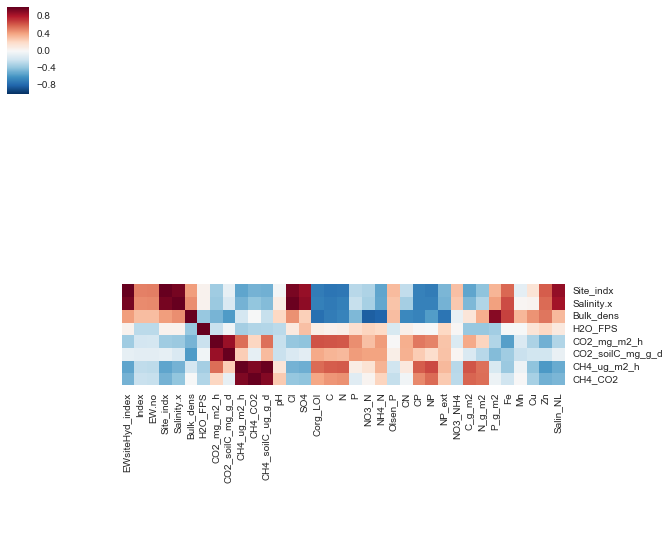

In [9]:
Soil_corr = Log_Soil_chem.corr() #correlation matrix

# Emphasize CH4 related subset
cm=sns.clustermap(Soil_corr.iloc[3:11,:], vmax=1, row_cluster=False, col_cluster=False, square=True);
# cm.cax.set_visible(False) - turns legend off, but doesn't fix whitespace
plt.sca(cm.ax_heatmap) # for tick rotation
plt.yticks(rotation=0)
#cm.savefig("Soil_Chem_CH4corr_SM_heat.pdf")

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

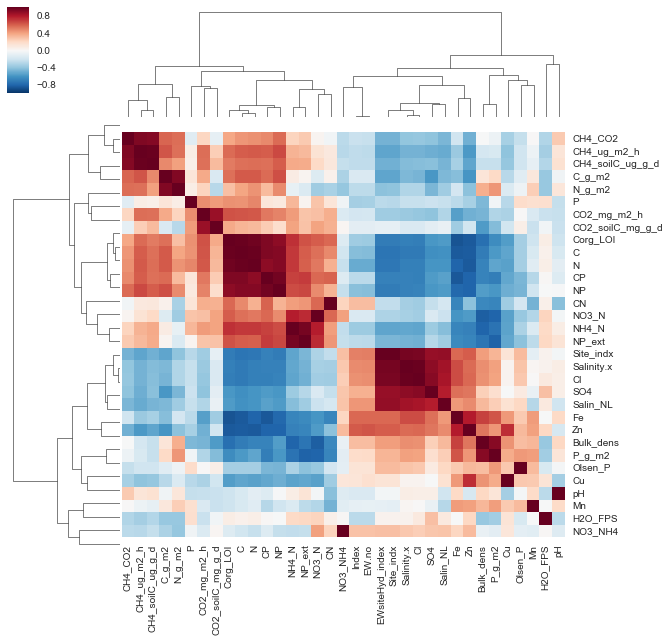

In [10]:
# Clustermap - ALL SOIL vars
cm2=sns.clustermap(Soil_corr.iloc[3:,:], vmax=1, row_cluster=True, col_cluster=True,  square=True);
plt.sca(cm2.ax_heatmap) # More on this in a minute
plt.yticks(rotation=0);

# cm.savefig("Soil_Chem_CH4corr_Big_heat_both_clusts.pdf")

### Get best vars and scatterplot

In [11]:
## Get top correlated variables by abs
# Soil_corr = Log_Soil_chem.corr() #correlation matrix

# Get CH4 corr data and abs. values
CH4_corrs =pd.DataFrame(Soil_corr['CH4_ug_m2_h'])
CH4_corrs['AbVal'] = abs(CH4_corrs)  # CH4_corrs.head(10)

# Cutoff at |r| > 0.45, sorted 
CH4_corrs_rF = CH4_corrs[CH4_corrs.AbVal > 0.45]                       # Impose cutoff,  .index gives only cols
CH4_corrs_rF = CH4_corrs_rF.sort_values(by='AbVal', ascending =0)    # make abs col
CH4_corrs_rF
CH4_corrs_rF0 = CH4_corrs_rF.iloc[3:,:]                              # drop autocorrelated, by inspection
CH4_corrs_rF10 = CH4_corrs_rF0.iloc[:,0:9]
CH4_corrs_top10 = CH4_corrs_rF10.sort_values(by='CH4_ug_m2_h', ascending =0)  # sort by orig cor (not abs)  

# Get var list
CH4_top_10 = CH4_corrs_top10.iloc[:,:9].index   # CH4_top_10 # CH4_corrs_top10 

### Check data distributions

In [12]:
Log_Soil_chem.columns

Index(['EWsiteHyd_index', 'Sample', 'MG_name', 'Index', 'Location', 'Pl_Sp',
       'EWcoastGroup', 'SALTgroup', 'LU', 'Depth', 'EW.no', 'iTag_name.x',
       'Site_indx', 'Salinity.x', 'Bulk_dens', 'H2O_FPS', 'CO2_mg_m2_h',
       'CO2_soilC_mg_g_d', 'CH4_ug_m2_h', 'CH4_CO2', 'CH4_soilC_ug_g_d', 'pH',
       'Cl', 'SO4', 'Corg_LOI', 'C', 'N', 'P', 'NO3_N', 'NH4_N', 'Olsen_P',
       'CN', 'CP', 'NP', 'NP_ext', 'NO3_NH4', 'C_g_m2', 'N_g_m2', 'P_g_m2',
       'Fe', 'Mn', 'Cu', 'Zn', 'Salin_NL'],
      dtype='object')

## Porewater corr

### Transform data

In [13]:
# log10 Porewater data
log_Pore_water = np.log10(Pore_water)
Log_Pore_water = pd.concat([Samp_info, log_Pore_water], axis=1)

### Make correlation matrix of soil variables

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5]),
 <a list of 9 Text yticklabel objects>)

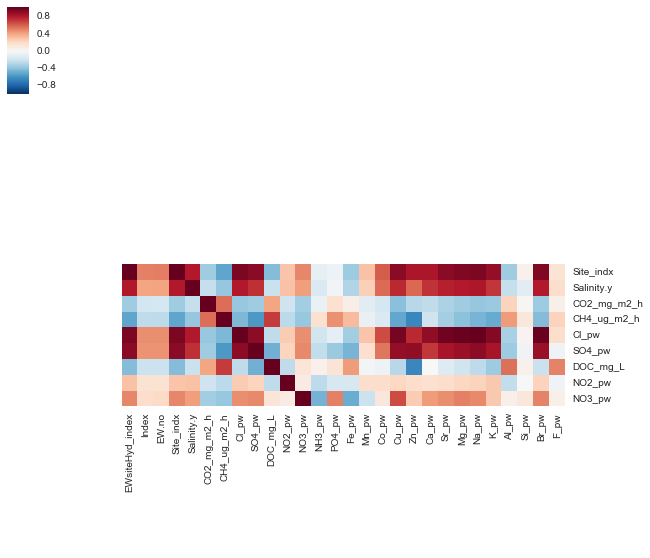

In [14]:
Log_PW_corr = Log_Pore_water.corr() #correlation matrix

# Emphasize CH4 related subset
cm=sns.clustermap(Log_PW_corr.iloc[3:12,:], vmax=1, row_cluster=False, col_cluster=False, square=True);
# cm.cax.set_visible(False)
plt.sca(cm.ax_heatmap) # More on this in a minute
plt.yticks(rotation=0)

# cm.savefig("Soil_PoreW_CH4corr_SM_heat.pdf")

### Get best vars and scatterplot

In [15]:
#Log_PW_corr = Log_Pore_water.corr()  #correlation matrix

PW_CH4_corrs =pd.DataFrame(Log_PW_corr['CH4_ug_m2_h'])
PW_CH4_corrs['AbVal'] = abs(PW_CH4_corrs)  # PW_corrs.head(10)
PW_CH4_corrs

# Cutoff at |r| > 0.45, sorted 
PW_corrs_rF = PW_CH4_corrs[PW_CH4_corrs.AbVal > 0.30]                # Impose cutoff,  .index gives only cols
PW_corrs_rF

##
PW_corrs_rF = PW_corrs_rF.sort_values(by='AbVal', ascending =0)    # make abs col
PW_corrs_rF

PW_corrs_rF0 = PW_corrs_rF.iloc[1:,:]                              # drop autocorrelated, by inspection
PW_corrs_rF10 = PW_corrs_rF0.iloc[:,0:9]
PW_corrs_top10 = PW_corrs_rF10.sort_values(by='CH4_ug_m2_h', ascending =0)  # sort by orig cor (not abs)  

# Get var list
PW_CH4_top10 = PW_corrs_top10.iloc[:,:9].index
# PW_CH4_top10 # PW_corrs_top10 

In [16]:
### Check distributions appropriate after log transform

In [17]:
## LASSO CV

## IMPORT colors tests

In [18]:
Sal_site_colors = pd.read_csv('Sal_siteColors_test.txt', sep='\t')
Sal_site_colors.columns = ['Location', 'color','Site']
# Sal_site_colors

In [19]:
Salpal3 = Sal_site_colors['color'].tolist()
Location = Sal_site_colors['Site'].tolist()
#Location
#Salpal3

#Salpal3 = pd.DataFrame(Sal_metaM['Salpal3_col'])
#Salpal3.to_list()

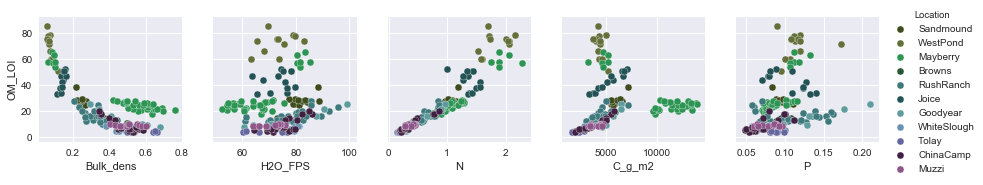

In [20]:
Site_or = ('Sandmound','WestPond','Mayberry','Browns','RushRanch','Joice','Goodyear','WhiteSlough','Tolay','ChinaCamp','Muzzi')

#sns.pairplot(y_vars=['OM_LOI'], x_vars = ['Bulk_dens','H2O_FPS','N','C_g_m2','P'], hue='Location', hue_order=Site_or, data=Sal_metaM)
sns.pairplot(y_vars=['OM_LOI'], x_vars = ['Bulk_dens','H2O_FPS','N','C_g_m2','P'], hue='Location', palette = Salpal3, hue_order=Site_or, data=Sal_metaM)


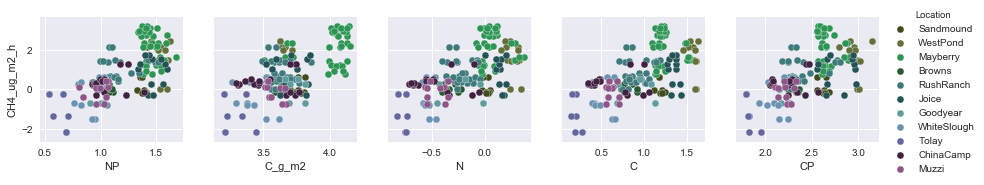

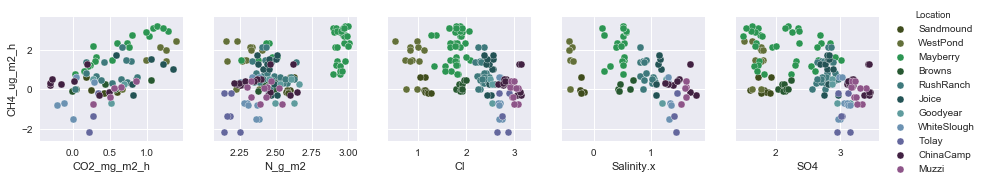

In [21]:
## Plot methane vars like this
sns.pairplot(y_vars=['CH4_ug_m2_h'], x_vars = CH4_top_10[0:5], hue='Location',  palette = Salpal3, hue_order=Site_or, data=Log_Soil_chem)
sns.pairplot(y_vars=['CH4_ug_m2_h'], x_vars = CH4_top_10[6:11], hue='Location', palette = Salpal3, hue_order=Site_or, data=Log_Soil_chem)

In [22]:
#kws = dict(s=50, linewidth=.5, edgecolor="w")
# hue_kws=dict(marker=["^", "^", "^", "^", "^", "^", "v", "v", "v", "v", "v"]
#sns.FacetGrid(y_vars=['CH4_ug_m2_h'], x_vars = CH4_top_10[6:11], hue='Location', hue_kws=dict(marker=["^", "^", "^", "^", "^", "^", "v", "v", "v", "v", "v"]), palette = Salpal3, hue_order=Site_or, data=Log_Soil_chem)

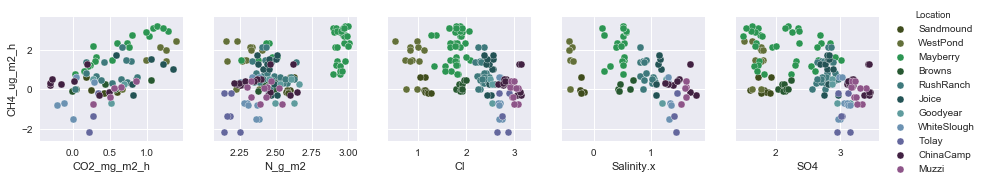

In [23]:
sns.pairplot(y_vars=['CH4_ug_m2_h'], x_vars = CH4_top_10[6:11], hue='Location', palette = Salpal3, hue_order=Site_or, data=Log_Soil_chem)


(<seaborn.axisgrid.FacetGrid at 0x117547780>,)

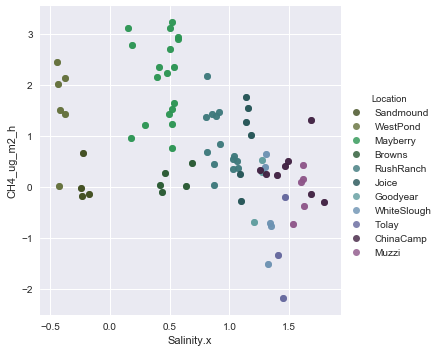

In [24]:
sns.lmplot(y='CH4_ug_m2_h', x = 'Salinity.x', fit_reg=False, hue='Location', palette = Salpal3, hue_order=Site_or, data=Log_Soil_chem),#  size=4)
#sns.lmplot( x="sepal_length", y="sepal_width", data=df, fit_reg=False, hue='species', legend=False)
